# Load Data

In [2]:
import torch               
import torchvision   
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.autograd as autograd        
from torch import Tensor              
import torch.nn as nn                
import torch.nn.functional as F         
import torch.optim as optim           
from torch.jit import script, trace  
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import zipfile
from zipfile import ZipFile
import re
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
import random
import copy
from tensorflow.keras.datasets import fashion_mnist
from torch.autograd import Variable
# Loads data
(trainx, trainy), (X_test, y_test) = fashion_mnist.load_data()

# Splits data
input_size = X_test.shape[1] ** 2
y_train = trainy[:50000]
X_train = trainx[:50000]
y_val = trainy[50000:]
X_val = trainx[50000:]

def filter(xs, ys, lbls):
    idxs = [i for (i, l) in enumerate(ys) if l in lbls]
    return xs[idxs, :], ys[idxs]

fm1lbls = [0, 1, 4, 5, 8]
X_train1, y_train1 = filter(X_train, y_train, fm1lbls)
X_val1, y_val1 = filter(X_val, y_val, fm1lbls)
X_test1, y_test1 = filter(X_test, y_test, fm1lbls)

fm2lbls = [2, 3, 6, 7, 9]
X_train2, y_train2 = filter(X_train, y_train, fm2lbls)
X_val2, y_val2 = filter(X_val, y_val, fm2lbls)
X_test2, y_test2 = filter(X_test, y_test, fm2lbls)



4423680/4422102 [==============================] - 0s 0us/step


In [3]:
'''Re-assigning the labels to 0-4 '''
#for mnist1
for i, ele in enumerate(y_train1):
  if ele == 4:
    y_train1[i] = 2
  elif ele == 5:
    y_train1[i] = 3
  elif ele == 8:
    y_train1[i] = 4

for i, ele in enumerate(y_test1):
  if ele == 4:
    y_test1[i] = 2
  elif ele == 5:
    y_test1[i] = 3
  elif ele == 8:
    y_test1[i] = 4

for i, ele in enumerate(y_val1):
  if ele == 4:
    y_val1[i] = 2
  elif ele == 5:
    y_val1[i] = 3
  elif ele == 8:
    y_val1[i] = 4

#for MNIST 2
for i, ele in enumerate(y_train2):
  if ele == 2:
    y_train2[i] = 0
  elif ele == 3:
    y_train2[i] = 1
  elif ele == 6:
    y_train2[i] = 2
  elif ele == 7:
    y_train2[i] = 3
  elif ele == 9:
    y_train2[i] = 4
  

for i, ele in enumerate(y_test2):
  if ele == 2:
    y_test2[i] = 0
  elif ele == 3:
    y_test2[i] = 1
  elif ele == 6:
    y_test2[i] = 2
  elif ele == 7:
    y_test2[i] = 3
  elif ele == 9:
    y_test2[i] = 4

for i, ele in enumerate(y_val2):
  if ele == 2:
    y_val2[i] = 0
  elif ele == 3:
    y_val2[i] = 1
  elif ele == 6:
    y_val2[i] = 2
  elif ele == 7:
    y_val2[i] = 3
  elif ele == 9:
    y_val2[i] = 4


In [4]:
# Creates train and validation data for Dataloader

X_train1 = X_train1.reshape(X_train1.shape[0],1,28,28)
X_val1 = X_val1.reshape(X_val1.shape[0],1,28,28)
X_test1 = X_test1.reshape(X_test1.shape[0],1,28,28)

X_train2 = X_train2.reshape(X_train2.shape[0],1,28,28)
X_val2 = X_val2.reshape(X_val2.shape[0],1,28,28)
X_test2 = X_test2.reshape(X_test2.shape[0],1,28,28)

traindata1 = []
traindata2 = []
for i in range(len(X_train1)):
   traindata1.append([X_train1[i], y_train1[i]])
for i in range(len(X_train2)):
   traindata2.append([X_train2[i], y_train2[i]])

valdata1 = []
valdata2 = []
for i in range(len(X_val1)):
  valdata1.append([X_val1[i],y_val1[i]])
for i in range(len(X_val2)):
  valdata2.append([X_val2[i],y_val2[i]])

testdata1 = []
testdata2 = []
for i in range(len(X_test1)):
  testdata1.append([X_test1[i],y_test1[i]])
for i in range(len(X_test2)):
  testdata2.append([X_test2[i],y_test2[i]])


# Model 

In [5]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1, 16, 5, padding=(1,1))
    self.conv2=nn.Conv2d(16, 32, 5, padding=(1,1))
    self.dropout = nn.Dropout()
    self.fc1 = nn.Linear(800, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 5)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [6]:
# Trains model
def train(learning_rate, epoch, traindata, valdata, testdata, model,device,batch):

  trainloader=torch.utils.data.DataLoader(traindata,batch_size=batch,shuffle=True)
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)

  for e in range(0, epoch):
    current_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
      input,label = data[0].to(device),data[1].to(device)
      optimizer.zero_grad()
      output = model(input.float())
      _,predicted = torch.max(output.data,1)
      total += label.size(0)
      correct += (predicted==label).sum().item()
      loss = criterion(output,label.long())
      loss.backward()
      optimizer.step()
      current_loss+=loss.item()
  
  # Last run: store test, val and training accuracies
  train_acc = (100*correct/total)
  train_err = current_loss/(i+1)
  val_acc, val_err = validate(valdata, batch, model, device)
  test_acc = testing(testdata, batch, model, device)

  return train_acc, train_err, val_acc, val_err, test_acc
  


In [7]:
# Validates model
def validate(valdata, batch, model, device):
  valloader = torch.utils.data.DataLoader(valdata, batch_size=batch, shuffle=True)
  criterion=nn.CrossEntropyLoss()
  correct = 0
  total = 0
  current_loss = 0
  i=0
  with torch.no_grad():
    for data in valloader:
      input,label = data[0].to(device),data[1].to(device)
      output = model(input.float())
      _,predicted=torch.max(output.data,1)
      total+=label.size(0)
      correct += (predicted==label).sum().item()
      loss=criterion(output,label.long())
      current_loss+=loss.item()
      i+=1
  print("Validation Accuracy: ", (100*correct/total),"%")

  return (100*correct/total), current_loss/(i)

#testing model
def testing(testdata, batch, model, device):
  testloader = torch.utils.data.DataLoader(testdata, batch_size=batch, shuffle=True)
  criterion=nn.CrossEntropyLoss()
  correct=0
  total=0
  i=0
  with torch.no_grad():
    for data in testloader:
      input,label = data[0].to(device), data[1].to(device)
      output = model(input.float())
      _,predicted = torch.max(output.data,1)
      total += label.size(0)
      correct += (predicted==label).sum().item()
      i+=1
  print("Testing Accuracy: ", (100*correct/total),"%")

  return (100*correct/total)

# Run

In [8]:
'''MNIST 2 '''
# Train the network using the parameter settings above 
torch.manual_seed(0)
torch.set_deterministic(True)
batch= 256
learning_rate=0.0001
epochs= 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN2=CNN()
CNN2.to(device)
train_acc2, train_loss2, val_acc2, val_loss2, test_acc2 = train(learning_rate, epochs, traindata2, valdata2, testdata2, CNN2, device, batch)

Validation Accuracy:  93.32663316582915 %
Testing Accuracy:  92.84 %


In [9]:
'''MNIST 1 '''
 
torch.manual_seed(0)
torch.set_deterministic(True)
batch= 256
learning_rate=0.0001
epochs= 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN1=CNN()
CNN1.to(device)
train_acc1, train_loss2, val_acc1, val_loss2, test_err1 = train(learning_rate, epochs, traindata1, valdata1, testdata1, CNN1, device, batch)

# Transfer Learning vs Random Initialization

In [ ]:
from tqdm import tqdm

#initialize the list which will store all the accuracies and loss for each percentages
l = len(traindata1)
test_accs = []
train_accs = []
val_accs = []
train_errs = []
val_errs = []

pre_test_accs = []
pre_train_accs = []
pre_val_accs = []
pre_train_errs = []
pre_val_errs = []

'''Compare random vs transfer learning for 5,10,...100% Fashion MNIST-1 training sets.'''
for i in tqdm(range(1, 21)):
  perc_traindata = traindata1[:int(l*5*i/100)] #Percentage of Fashion MNIST-1

  #Initialize all layers to the trained CNN2 layers except for the classifier layer fc3
  pre_CNN = CNN()
  pre_CNN.to(device)
  pre_CNN.conv1.weight.data = CNN2.conv1.weight.data
  pre_CNN.conv2.weight.data = CNN2.conv2.weight.data
  pre_CNN.fc1.weight.data = CNN2.fc1.weight.data
  pre_CNN.fc2.weight.data = CNN2.fc2.weight.data

  pre_train_acc, pre_train_err, pre_val_acc, pre_val_err, pre_test_acc = train(learning_rate, epochs, perc_traindata, valdata1, testdata1, pre_CNN, device, batch)
  pre_test_accs.append(pre_test_acc)
  pre_train_accs.append(pre_train_acc)
  pre_train_errs.append(pre_train_err)
  pre_val_accs.append(pre_val_acc)
  pre_val_errs.append(pre_val_err)

  #Randomly initialized new CNN instance
  CNN_1=CNN()
  CNN_1.to(device)
  train_acc1, train_err1, val_acc1, val_err1, test_acc1 = train(learning_rate, epochs, perc_traindata, valdata1, testdata1, CNN_1, device, batch)
  test_accs.append(test_acc1)
  train_accs.append(train_acc1)
  val_accs.append(val_acc1)
  train_errs.append(train_err1)
  val_errs.append(val_err1)


# Plots

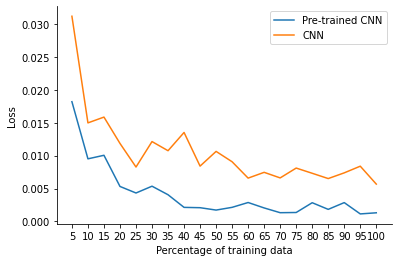

In [17]:
# Training loss Plots
import matplotlib.pyplot as plt

ind = ['5', '10', '15', '20', '25', '30','35', '40', '45', '50','55', '60','65', '70','75', '80','85', '90','95', '100']
fig, ax = plt.subplots()
ax.plot(ind, pre_train_errs, label = 'Pre-trained CNN')
ax.plot(ind, train_errs, label = 'CNN')
ax.set_xlabel("Percentage of training data")
ax.set_ylabel("Loss")
ax.legend(loc="upper right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

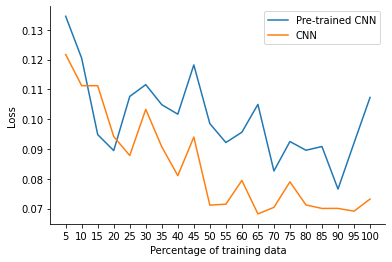

In [15]:
#Validation loss plots
ind = ['5', '10', '15', '20', '25', '30','35', '40', '45', '50','55', '60','65', '70','75', '80','85', '90','95', '100']
fig, ax = plt.subplots()
ax.plot(ind, pre_val_errs, label = 'Pre-trained CNN')
ax.plot(ind, val_errs, label = 'CNN')
ax.set_xlabel("Percentage of training data")
ax.set_ylabel("Loss")
ax.legend(loc="upper right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Best Models

In [21]:
# best_i = np.argmin(val_errs)
# pre_best_i = np.argmin(pre_val_errs)

# print( "The best model using transfer learning was when using {}%, with validation accuracy of {}, training accuracy of {} and test accuracy of {}".format(str(pre_best_i * 5), pre_val_accs[pre_best_i], pre_train_accs[pre_best_i], pre_test_accs[pre_best_i]))

# print("The best model for random initialization was when using {}%, with validation accuracy of {}, training accuracy of {} and test accuracy of {}".format(str(best_i * 5), val_accs[best_i], train_accs[best_i], test_accs[best_i]))






The best model using transfer learning was when using 85, with validation accuracy of 98.82587064676616, training accuracy of 99.93326511545135 and test accuracy of 98.68
The best model for random initialization was when using 60, with validation accuracy of 98.60696517412936, training accuracy of 99.77822953243393 and test accuracy of 98.22
